In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pytorch_model_summary import summary
from sklearn.model_selection import train_test_split
from tqdm import tqdm


def load_data(data_path, test_size, validation_size):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
    """
    
    print("Loading data...")
    
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to tensors
    X = torch.Tensor(data["mfcc"])
    y = torch.Tensor(data["labels"]).argmax(axis=1).type(torch.LongTensor)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    # reshape data for an input layer
    X_train = X_train[..., np.newaxis].view(-1, 1, 130, 40)
    X_validation = X_validation[..., np.newaxis].view(-1, 1, 130, 40)
    X_test = X_test[..., np.newaxis].view(-1, 1, 130, 40)
    
    print("Data succesfully loaded!")
        
    return X_train, X_validation, X_test, y_train, y_validation, y_test

    
class Model(nn.Module):
    
    def __init__(self):
        
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (3, 3)) # 1 channel * 130 * 40 = 5200 (channels, height, width)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, (3, 3))
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, (2, 2))
        self.norm3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 16 * 5, 128) # 16 * 5 -> shape after last convolution layer
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

        
    def forward(self, x):
        
        # 1st convolutional
        x = F.relu( self.conv1(x) )
        x = F.max_pool2d(x, kernel_size=(3, 3), stride=(2, 2), padding=1)
        x = self.norm1(x)

        # 2nd convolutional
        x = F.relu( self.conv2(x) )
        x = F.max_pool2d(x, kernel_size=(3, 3), stride=(2, 2), padding=1)
        x = self.norm2(x)

        # 3rd convolutional
        x = F.relu( self.conv3(x) )
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2), padding=1)
        x = self.norm3(x)
        
        # 1st linear
        x = F.relu( self.fc1(torch.flatten(x, 1, -1)) )
        x = self.dropout(x)
        
        # 2nd linear = output layer
        output = F.softmax( self.fc2(x) , dim=1)
        
        return output
    
    
    def compile(self, optimizer, loss_function):
        
        self.model_name = f"model-{int(time.time())}"
        self.optimizer = optimizer
        self.loss_function = loss_function
        print(self)
    
    
    def fit(self, X_train, y_train, validation_data, epochs, batch_size, log=True):
        
        # declare history with default values before training
        history = {'acc': [0.1], 'loss': [2.3026], 'val_acc': [0.1], 'val_loss': [2.3026]}
        num_batches = math.ceil(len(X_train) / batch_size)
        
        # iteration over epochs
        for epoch in tqdm(range(epochs)):
            # reset metrics after each epoch
            if log:
                running_loss = 0.0
                running_acc = 0.0
                self.train()
            
            # iteration over batches
            for i in range(0, len(X_train), batch_size):
                # batch data and load to device
                X_batch = X_train[i:i+batch_size].to(device)
                y_batch = y_train[i:i+batch_size].to(device)

                # forward and backward pass
                self.zero_grad()
                outputs = self(X_batch)
                loss = self.loss_function(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

                # calculate running statistics
                if log:
                    matches = [torch.argmax(j)==k for j, k in zip(outputs, y_batch)]
                    running_acc += matches.count(True)/len(matches)
                    running_loss += loss.item()

            # add stats to history
            if log:
                running_acc /= num_batches
                running_loss /= num_batches
                running_val_acc, running_val_loss = self.test(validation_data[0], validation_data[1])
                history['acc'].append(round(float(running_acc),4))
                history['loss'].append(round(float(running_loss),4))
                history['val_acc'].append(round(float(running_val_acc),4))
                history['val_loss'].append(round(float(running_val_loss),4))            
            
        return history

        
    def test(self, X, y, out=False):
        
        self.eval()
        
        with torch.no_grad():
            outputs = self(X.to(device))
            matches  = [torch.argmax(i)==j for i, j in zip(outputs, y)]
            acc = round(float(matches.count(True)/len(matches)),4)
            loss = round(float(self.loss_function(outputs, y.to(device))),4)
            
        if out:
            print(f"Test acc: {acc} Test loss: {loss}")
            
        return acc, loss 


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history["acc"], label="train accuracy")
    axs[0].plot(history["val_acc"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("")

    # create error sublpot
    axs[1].plot(history["loss"], label="train error")
    axs[1].plot(history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("")

    plt.show()
    
    
    
if __name__ == "__main__":
    # path to json file that stores MFCCs and genre labels for each processed segment
    DATA_PATH = "/data/shared/GTZAN-DATASET/data_10.json"
    
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("Running on the GPU")
        
    else:
        device = torch.device("cpu")
        print("Running on the CPU")
        
    try:
        X_train
        
    except NameError:
        X_train, X_validation, X_test, y_train, y_validation, y_test = load_data(
            DATA_PATH, 
            test_size=0.10, 
            validation_size=0.10)

    model = Model().to(device)
    model.compile(optim.Adam([
                        {'params': model.conv1.parameters(), 'weight_decay': 1e-4},
                        {'params': model.norm1.parameters()},
                        {'params': model.conv2.parameters(), 'weight_decay': 1e-4},
                        {'params': model.norm2.parameters()},
                        {'params': model.conv3.parameters(), 'weight_decay': 1e-3},
                        {'params': model.norm3.parameters()},
                        {'params': model.fc1.parameters(), 'weight_decay': 1e-4},
                        {'params': model.fc2.parameters(), 'weight_decay': 1e-3}
                    ], lr=1e-3), 
                    nn.CrossEntropyLoss())
    
    print(summary(model, torch.rand(1, 1, 130, 40).to(device)), sep='\n')

Running on the GPU
Loading data...
Data succesfully loaded!
Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2560, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (loss_function): CrossEntropyLoss()
)
------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 128, 38]             320             320
     BatchNorm2d-2      [1, 32, 64, 19]              6

100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


Test acc: 0.784 Test loss: 1.6814


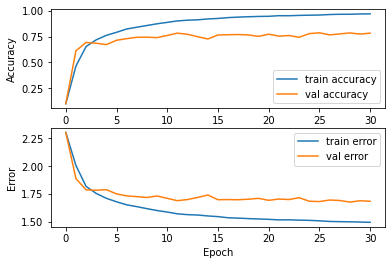

Max_val_acc: 0.7867   Max_train_acc: 0.9702
Min_val_loss: 1.6763   Min_train_loss: 1.4946


In [2]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_validation, y_validation), 
    epochs=30, 
    batch_size=256,
    log=True)
    
model.test(X_test, y_test, out=True)
plot_history(history)
print("Max_val_acc:", max(history['val_acc']), "  Max_train_acc:", max(history['acc']))
print("Min_val_loss:", min(history['val_loss']), "  Min_train_loss:", min(history['loss']))